In [17]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import minmax_scale
import cv2
import os
import shutil

import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

print(tf.__version__)
print(f'TensorFlow built with cuda? {tf.test.is_built_with_cuda()}')
print(f'TensorFlow built with GPU support? {tf.test.is_built_with_gpu_support()}')

2.16.2
TensorFlow built with cuda? True
TensorFlow built with GPU support? True


In [18]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [19]:
base_dir = './images/overlap'

images_dir ='./images/overlap/tiles'
masks_dir = './images/overlap/masks'

images_listdir = [img for img in os.listdir(images_dir) if img.endswith('jpg')]
masks_listdir = [img for img in os.listdir(masks_dir) if img.endswith('jpg')]

print(len(images_listdir))
print(len(masks_listdir))

521
521


In [20]:
img_train, img_test = train_test_split(images_listdir, test_size=0.20)
len(img_train)

416

In [21]:
masks_train, masks_test = train_test_split(masks_listdir, test_size=0.20)
len(masks_train)

416

In [22]:
img_train_path = os.path.join(images_dir, 'train')

if not os.path.isdir(img_train_path):
    os.makedirs(img_train_path)

for img in img_train:
    src = os.path.join(images_dir, img)
    dst = os.path.join(img_train_path, img)
    shutil.copyfile(src, dst)


img_test_path = os.path.join(images_dir, 'test')

if not os.path.isdir(img_test_path):
    os.makedirs(img_test_path)

for img in img_test:
    src = os.path.join(images_dir, img)
    dst = os.path.join(img_test_path, img)
    shutil.copyfile(src, dst)

In [23]:
masks_train_path = os.path.join(masks_dir, 'train')

if not os.path.isdir(masks_train_path):
    os.makedirs(masks_train_path)

for img in masks_train:
    src = os.path.join(masks_dir, img)
    dst = os.path.join(masks_train_path, img)
    shutil.copyfile(src, dst)

masks_test_path = os.path.join(masks_dir, 'test')

if not os.path.isdir(masks_test_path):
    os.makedirs(masks_test_path)

for img in masks_test:
    src = os.path.join(masks_dir, img)
    dst = os.path.join(masks_test_path, img)
    shutil.copyfile(src, dst)

In [24]:
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [25]:
image_size = 512
input_image_size = (image_size, image_size)

def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

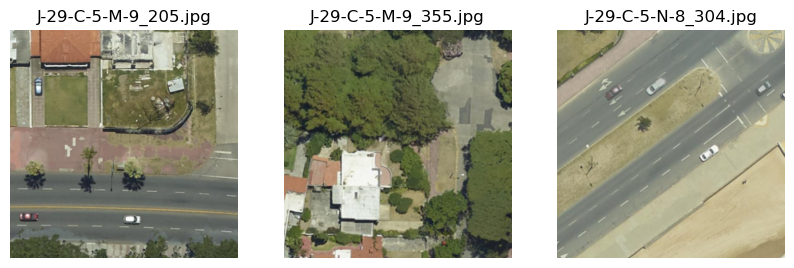

In [26]:
rows = 1
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10, 10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        input_path = f"{images_dir}/{random_images[i]}"
        img = read_image(input_path)
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

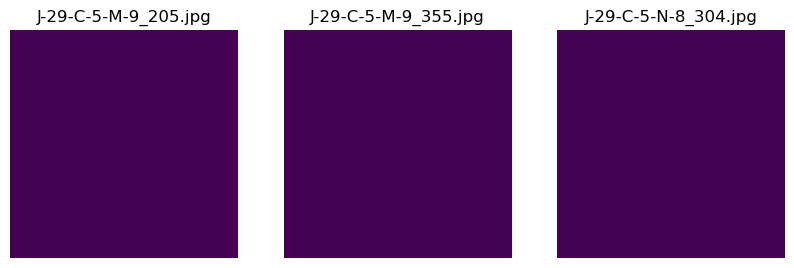

In [27]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [28]:
MASKS = np.zeros((1, image_size, image_size, 1), dtype=bool)
IMAGES = np.zeros((1, image_size, image_size, 3), dtype=np.uint8)


for j, file in enumerate(img_train):   ##the smaller, the faster
    image = read_image(f"{img_train_path}/{file}")
    image_ex = np.expand_dims(image, axis=0)
    IMAGES = np.vstack([IMAGES, image_ex])
    file2 = file[0:-4]+'.jpg'
    mask = read_image(f"{masks_dir}/{file2}")
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = mask.reshape(image_size, image_size, 1)
    mask_ex = np.expand_dims(mask, axis=0)
    MASKS = np.vstack([MASKS, mask_ex])

In [29]:
TMASKS = np.zeros((1, image_size, image_size,1), dtype=bool)
TIMAGES = np.zeros((1, image_size, image_size,3),dtype=np.uint8)

for j, file in enumerate(img_test):
    image = read_image(f"{img_test_path}/{file}")
    image_ex = np.expand_dims(image, axis=0)
    TIMAGES = np.vstack([TIMAGES, image_ex])
    file2 = file[0:-4]+'.jpg'
    mask = read_image(f"{masks_dir}/{file2}")
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = mask.reshape(image_size, image_size, 1)
    mask_ex = np.expand_dims(mask, axis=0)
    TMASKS = np.vstack([TMASKS, mask_ex])

In [30]:
images=np.array(IMAGES)
masks=np.array(MASKS)
print('Train')
print(images.shape, masks.shape)

test_images=np.array(TIMAGES)
test_masks=np.array(TMASKS)

print('Test')
print(test_images.shape, test_masks.shape)

Train
(417, 512, 512, 3) (417, 512, 512, 1)
Test
(106, 512, 512, 3) (106, 512, 512, 1)


In [31]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.2, random_state=42)

In [16]:
print(len(images_train), len(masks_train))

333 333


In [ ]:
# from tensorflow.keras import backend as K
# from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras.optimizers import Adam

from tensorflow import keras

def iou_coeff(y_true, y_pred):
    # Calcula la intersección entre el y_true y y_pred
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    # Calcula la unión
    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
    # Calcula el coeficiente de IoU
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    return iou

def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)

    bridge = conv_block(pool3, 512)

    decode2 = decoder_block(bridge, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
unet_model = Unet((image_size, image_size, 3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy')
unet_model.summary()

In [ ]:
unet_result = unet_model.fit(
    images_train, masks_train,
    validation_split = 0.2, batch_size = 1, epochs = 20)

In [ ]:
unet_model.save('./modelos/unet_512_20epochs_cpu.keras')

In [ ]:
import keras

unet_model = keras.saving.load_model('./modelos/unet_512_20epochs_cpu.keras')

In [ ]:
loss, acc = unet_model.evaluate(test_images, test_masks, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))
